# Deep Learning: II

*S. R. Taylor (2025)*

This lecture and notebook are based on the "NeuralNetworks", and "TensorFloeCodeOnly" lectures of of G. Richards' "Astrostatistics" class at Drexel University (PHYS 440/540, https://github.com/gtrichards/PHYS_440_540), which in turn are based on materials from Andy Connolly, and Ivezic et al. Chapter 9, Andy Connolly's [blog](http://connolly.github.io/introAstroML/blog/regression.html), and Aurelien Geron's [book](https://github.com/ageron/handson-ml2). 

##### Reading:

- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 9.
- Many blogs and videos.
- Free online book! http://neuralnetworksanddeeplearning.com/index.html

---

## Contents
* [Photo-z With Deep Learning](#one)
* [Convolutional Neural Networks (CNNs)](#two)
* [Autoencoders](#three)
* [Generative Adversarial Networks (GANs)](#four)
* [Normalizing Flows](#five)
* [Transformers](#six)
    
---

***Exercises required for class participation are in <font color='red'>red</font>.***

---

Before starting today, let's install the two big Deep Learning packages out there. [Tensorflow](https://www.tensorflow.org/) and [PyTorch](https://pytorch.org/)-- the rivalry essentially boils down to Google versus Facebook. 

In [4]:
# !pip3 install --upgrade pip

#### Tensorflow

In [5]:
# !pip3 install tensorflow

#### PyTorch

In [6]:
# !pip3 install torch torchvision

#### Keras

**[Keras](https://keras.io/)** is a deep learning API. Essentially it is Scikit-Learn for deep neural networks.

Keras needs a computational backend to handle the heavy computation.  Three popular (open sources) deep learning libraries are [TensorFlow](https://www.tensorflow.org/), Microsoft Cognitive Toolkit, and [Theano](http://www.deeplearning.net/software/theano/). TensorFlow now comes bundled with a version of Keras and that's what we'll use here (actually TensorFlow 2). PyTorch is another option. If you apply for a data-science job in industry knowing one of these tools might be the most useful thing for you to have learned.

In short, for neural networks:

> numpy -> tensorflow

> sklearn -> keras

In the same way that you can build a linear regression algorithm in numpy without using sklearn, you can build a neural network algorithm (not to mention linear regression) in tensorflow without using keras.  But just as sklearn makes our life easier, so too does keras.

## Photo-z with deep learning <a class="anchor" id="one"></a>

An important problem in galaxy imaging is being able to use observed galaxy color data to estimate its redshift. This is sometimes called "photo-z". Now, on your humble computer, you will build a deep neural network that is trained on a sample of SDSS galaxy color data. You'll see that `pytorch` makes this quite easy.

In [8]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torchdata

from astroML.datasets import fetch_sdss_specgals
from astroML.utils.decorators import pickle_results

from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

Read in and prepare the SDSS data.

In [9]:
# Fetch and prepare the data
data = fetch_sdss_specgals()

# put magnitudes into array
# normalize to zero mean and unit variance for easier training
datanormed = np.zeros((len(data), 6), 
                      dtype=np.float32)
for i, band in enumerate(['u', 'g', 'r', 'i', 'z']):
    band = 'modelMag_' + band
    datanormed[:, i] = ((data[band] - data[band].mean()) / 
                        data[band].std())

# put redshifts into array
datanormed[:, 5] = data['z']

Let's define a little helper class that will make our network. It is initialized with a given number of neurons in the single hidden layer. These neurons in the hidden layer connect to $5$ input variables (colors) and spits out 1 variable (redshift). You can also see that it uses ReLU activation for the neurons.

In [10]:
# define structure of neural net
class Net(nn.Module):
    def __init__(self, nhidden):
        super(Net, self).__init__()
        self.fc_h = nn.Linear(5, nhidden)
        self.fc_o = nn.Linear(nhidden, 1)

    def forward(self, x):
        h = F.relu(self.fc_h(x))
        z = self.fc_o(h)
        return z

Do a train-test split on the data.

In [11]:
# split data into 9:1 train:test
dataset = torchdata.TensorDataset(torch.tensor(datanormed[:, 0:5]),
                                  torch.tensor(datanormed[:, 5]).view(-1, 1))
trainnum = datanormed.shape[0] // 10 * 9
traindata, testdata = torchdata.random_split(dataset, 
                                             [trainnum, datanormed.shape[0] - trainnum])
traindataloader = torchdata.DataLoader(traindata, 
                                       batch_size=128, 
                                       shuffle=True)

Define a function to train the neural network. This looks like a lot of code, but the first block is the key. The network will have $4$ neurons in the hidden layer, and will use stochastic gradient descent to train the weights and biases.

In [12]:
@pickle_results('NNphotoz.pkl')
def train_NN():
    # 4 neurons in hidden layer
    model = Net(4)
    # MSE loss
    criterion = torch.nn.MSELoss(reduction='sum') 
    # stochastic gradient descent
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001) 
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                           verbose=True, 
                                                           patience=5, 
                                                           threshold=1e-3)

    min_valid_loss = float('inf')
    badepochs = 0
    for t in range(100):
        train_loss = 0
        for i, databatch in enumerate(traindataloader, 0):
            photometry, redshifts = databatch
            optimizer.zero_grad()
            z_pred = model(photometry)
            loss = criterion(z_pred, redshifts)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        with torch.no_grad():
            photometry = testdata[:][0]
            redshifts = testdata[:][1]
            z_pred = model(photometry)
            valid_loss = criterion(z_pred, redshifts)
            if t % 10 == 0:
                print('Epoch %3i: train loss %0.3e validation loss %0.3e' % (t, \
                        train_loss / len(traindata), valid_loss / len(testdata)))
            # stop training if validation loss has not fallen in 10 epochs
            if valid_loss > min_valid_loss*(1-1e-3):
                badepochs += 1
            else:
                min_valid_loss = valid_loss
                badepochs = 0
            if badepochs == 10:
                print('Finished training')
                break
        scheduler.step(valid_loss)
    return model

Let's train this thing. It should take about five minutes. 

In [13]:
model = train_NN()

@pickle_results: computing results and saving to 'NNphotoz.pkl'


/home/deshmus/Documents/GitHub/astr_8070_s25/venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch   0: train loss 9.866e-04 validation loss 6.898e-04
Epoch  10: train loss 5.930e-04 validation loss 5.893e-04
Epoch  20: train loss 5.708e-04 validation loss 5.702e-04
Epoch  30: train loss 5.632e-04 validation loss 5.618e-04
Epoch  40: train loss 5.591e-04 validation loss 5.589e-04
Epoch  50: train loss 5.568e-04 validation loss 5.582e-04
Epoch  60: train loss 5.534e-04 validation loss 5.555e-04
Finished training


In [14]:
print(model)

Net(
  (fc_h): Linear(in_features=5, out_features=4, bias=True)
  (fc_o): Linear(in_features=4, out_features=1, bias=True)
)


Plot the results.

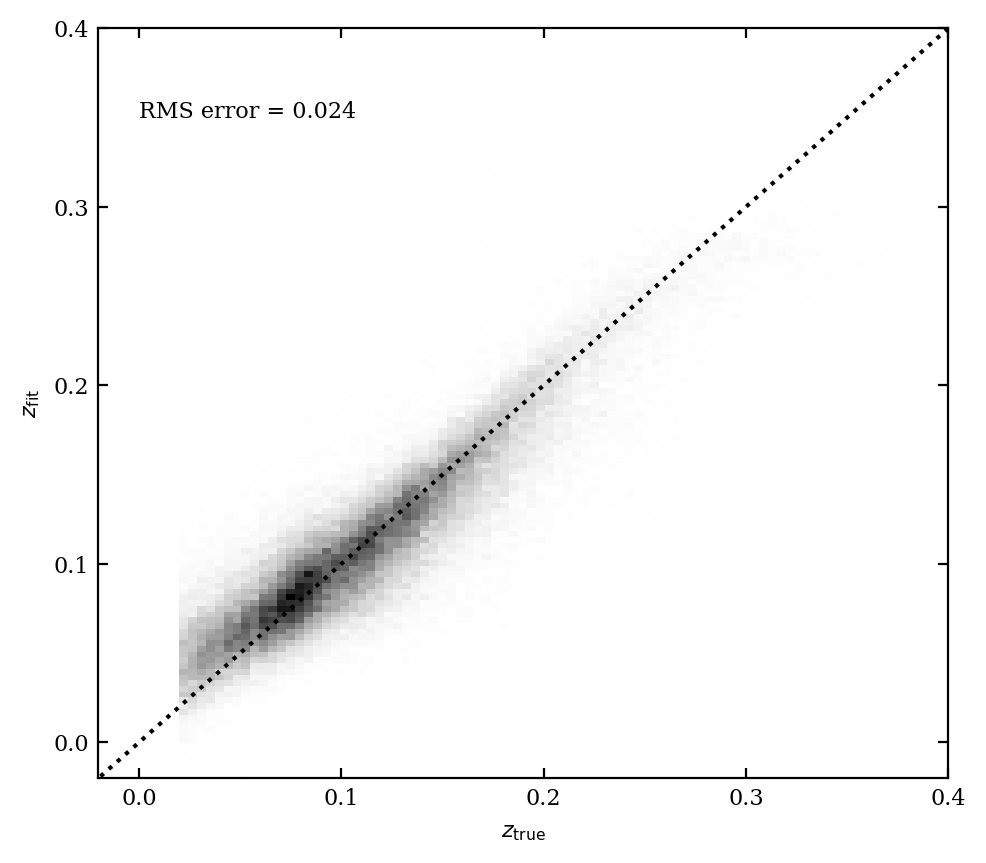

In [15]:
# plot the results
with torch.no_grad():
    photometry = testdata[:][0]
    redshifts = testdata[:][1]
    z_pred = model(photometry)
    fig = plt.figure(figsize=(5, 5))
    fig.subplots_adjust(wspace=0.25,
                        left=0.1, right=0.95,
                        bottom=0.15, top=0.9)

    ax = plt.axes()
    H, zs_bins, zp_bins = np.histogram2d(redshifts.numpy().flatten(), 
                                         z_pred.numpy().flatten(), 151)
    ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
               extent=[zs_bins[0], zs_bins[-1], zp_bins[0], zp_bins[-1]],
               cmap=plt.cm.binary)
    ax.plot([-0.1, 0.4], [-0.1, 0.4], ':k')
    rms = np.sqrt(np.mean((z_pred-redshifts).numpy()**2))
    
    ax.text(0, 0.35, 'RMS error = %0.3f' % np.sqrt(np.mean((z_pred-
                                                            redshifts).numpy()**2)))
    ax.set_xlim(-0.02, 0.4001)
    ax.set_ylim(-0.02, 0.4001)
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
    
    ax.set_xlabel(r'$z_{\rm true}$')
    ax.set_ylabel(r'$z_{\rm fit}$')
    
    plt.show()

Not bad at all! Still, this was a relatively simple fully-connected network. Other problems will require more complexity...

## Convolutional Neural Networks (CNNs) <a class="anchor" id="two"></a>

Recent interest in neural networks surged in 2012 when a team using a deep **[convolutional neural network (CNN)](https://en.wikipedia.org/wiki/Convolutional_neural_network)** acheived record results classifying objects in the [ImageNet](http://image-net.org/) data set.

The idea behind CNNs is inspired by human visual perception. ***Each neuron in your visual cortex doesn't "see" all of what your eye can see at once*** and some neurons are more sensitive to one pattern over another (e.g., horizontal lines vs. vertical lines).  

Moreover, the simplest deeply connected neural networks would choke on "real" data which has far more than 28x28 pixels, and would require following tens of millions of connections. So we use a combination of 
- "convolution"
- "pooling" 

to reduce the dimensionality of the data first.

![Ivezic Figure 9.19](https://www.astroml.org/_images/fig_cnn_1.png)

### Convolutional Layers

In a convolutional layer, each neuron is not connected to each neuron in the previous layer, but only those that are within its "field of view" as defined by a kernel (filter).  We slide the kernel over the input layer and the value in the next layer depends only on those pixels.

![](https://miro.medium.com/max/4800/1*GcI7G-JLAQiEoCON7xFbhg.gif)

Here's another perspective that helps to visualize going from one layer to the next.

![Convolution example](https://developer.apple.com/library/content/documentation/Performance/Conceptual/vImage/Art/kernel_convolution.jpg)

Choosing a filter (kernel) with a certain pattern can help recognize certain types of features (like horizontal aor vertical lines).

![vertical filter](https://miro.medium.com/max/1338/1*7IEbBib7Yc7qST5IGQoYXA.jpeg)

![horizontal filter](https://miro.medium.com/max/1238/1*PSSAaH2pZbl5bK3Ef_zk4A.jpeg)

The purpose of the convolutional layers is really to capture high-level features in the images, like edges. 

### Pooling Layers

It is common to follow the convolutional layer by a so-called "pooling layer", essentially to reduce the amount of data that needs to be processed.  The full architechture of a CNN might look something like this:

![CNN Example](https://www.researchgate.net/profile/Xian_Wei2/publication/331986652/figure/fig1/AS:740547106988032@1553571597647/The-classic-structure-of-CNN-It-consists-of-two-modules-Feature-extraction-module-and.ppm)

Where the pooling layers are reducing the number of pixels by averaging, summing, taking the max, etc. "**Max Pool**" is the most popular, and literally corresponds to taking the maximum of the convolution.

![Pooling example](https://miro.medium.com/max/1000/1*ydNsGDxMldAiq7b96GDQwg.jpeg)

or another way to see this is...

![](https://miro.medium.com/max/792/1*uoWYsCV5vBU8SHFPAPao-w.gif)

When we are done with convolution and pooling, the output gets fed into a regular, fully connected neural network that outputs the predictions.

- This is clearly much more sophisticated than our basic fully-connected multi-layer perceptron. "Deep" networks consist of tens of layers with thousands of neurons. **These large networks have become usable thanks to two breakthroughs: the use of sparse layers, and the power of graphics processing units (GPUs).**


- Sparse layers or convolutional layers in a deep network contain a large number of hidden nodes but very few synapses. The sparseness arises from the relatively small size of a typical convolution kernel (15x15 is a large kernel), so a hidden node representing one output of the convolution is connected to only a few input nodes. Compare this the our previous perceptron, in which every hidden node was connected to every input node.


- Even though the total number of connections is greatly reduced in the sparse layers, the total number of nodes and connections in a modern deep network is still enormous. Luckily, training these networks turns out to be a great task for GPU acceleration.


For further study, there are lots of resources for CNNs online.  For example, see
https://medium.com/analytics-vidhya/convolutional-neural-networks-cnn-explained-step-by-step-69137a54e5e7

The following cells are from Geron, Chapter 10, see 
https://github.com/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb

We'll start by introducing the **Fashion MNIST data set**. The next cells load the data, define test, trainging, and validation sets; normalize the data; display an example image; list the possible target values ($y$), and show a 4x10 grid of examples.

In [16]:
import tensorflow as tf
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

print(X_train_full.shape)
print(X_test.shape)

X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

2025-04-03 13:57:07.979801: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-03 13:57:08.074889: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743706628.110848  416544 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743706628.121938  416544 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743706628.202017  416544 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)
(55000, 28, 28)
(5000, 28, 28)
(10000, 28, 28)


This data set is a huge collection of images of items of clothing.

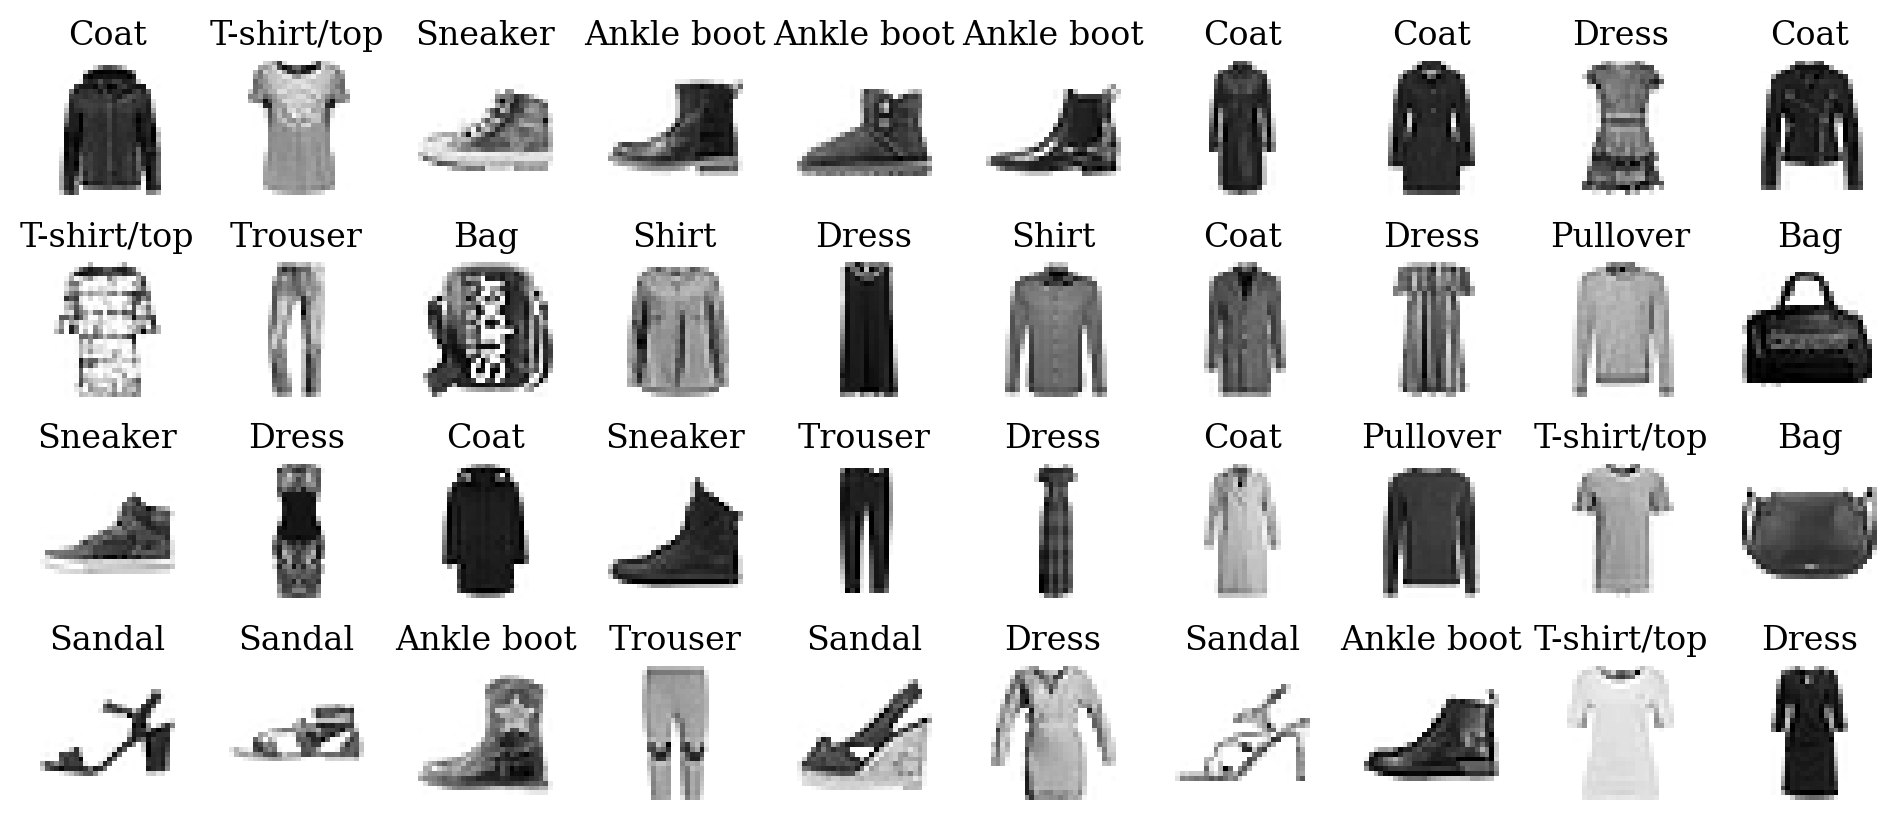

In [17]:
# Let's make a list of class names that we can refer to.
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Plot 4x10 array of images from the Fashion MNIST database
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest", origin='upper')
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

We'll use `tensorflow` on this data set, through it's handy API `keras`. Since these are images and we want to preserve contextual information like edges, we'll build a CNN.

In [18]:
import tensorflow as tf
from tensorflow import keras

keras.backend.clear_session() # Make sure that we are starting a new model and not adding to an earlier one
np.random.seed(42) # Set the numpy and tensorflow random seeds so that we all get the same answer
tf.random.set_seed(42)

Normalize and prepare the data to pass into a network.

In [19]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std


# Need to reshape for CNN
X_train = X_train[:, :, :, np.newaxis]
X_valid = X_valid[:,  :, :, np.newaxis]
X_test = X_test[:, :, :, np.newaxis]

print(len(X_train))
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

55000
(55000, 28, 28, 1)
(5000, 28, 28, 1)
(10000, 28, 28, 1)


The next cell looks like a lot, but really it is just a sequential declaration of different types of layer in the network. It is a combination of **2D Convolution layers** (feature finding), **Max Pooling layers** (data reduction), folloed by some **Dense layers** (fully-connected layers at the end of the network for classification) and some **Dropout** incorporated to strengthen the overall network and make sure all the neurons are actually pulling their weight.

In [20]:
model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[28, 28, 1]),
    keras.layers.Conv2D(filters=64, kernel_size=7, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),  
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])   

/home/deshmus/Documents/GitHub/astr_8070_s25/venv/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
2025-04-03 13:57:31.695470: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [21]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,413,834 (5.39 MB)

 Trainable params: 1,413,834 (5.39 MB)

 Non-trainable params: 0 (0.00 B)

None


**That's right...your CNN has ~1.5 million parameters that you are going to try to optimize on your machine...**

We'll only go through one epoch of optimization, but hopefully that will be enough to get us above $50\%$ accuracy.

In [22]:
#### This may take a while! Hopefully no more than 5 minutes for 1 epoch.
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
clf = model.fit(X_train, y_train, epochs=1, validation_data=(X_valid, y_valid))

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 158s 91ms/step - accuracy: 0.6378 - loss: 1.0079 - val_accuracy: 0.8482 - val_loss: 0.3961


In [23]:
# Evaluate the test set
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.8474 - loss: 0.4169


[0.4141443371772766, 0.847100019454956]

Predict values for first 3 test objects

In [24]:
X_new = X_test[:3]
y_proba = model.predict(X_new).round(2)
print(y_proba)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
[[0.   0.   0.   0.   0.   0.   0.   0.04 0.   0.96]
 [0.   0.   0.99 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]]


So, you can see that the output is a probability that the object belongs to each class (which has to sum to 1 across all the classes).  If we just want an "answer", we assign it to the class with the highest probability (done here with `predict_classes`).

In [25]:
y_pred = np.argmax(model.predict(X_new), axis=-1) #New way
print(y_pred)
print(np.array(class_names)[y_pred])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[9 2 1]
['Ankle boot' 'Pullover' 'Trouser']


Let's plot those and see if the predictions make sense.

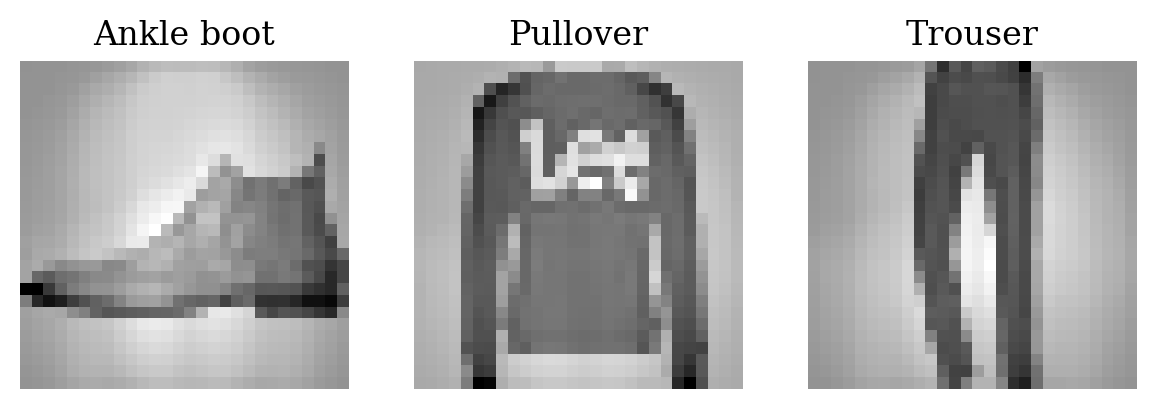

In [26]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest", origin='upper')
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Note that after you fit your model, you can save it and reload it at some later time (which is good because some models might take hours to train!)

In [27]:
# Save model
model.save("my_keras_model.h5")

# Reload model
model = keras.models.load_model("my_keras_model.h5")

Let's predict the values for 10 random objects. Display them with their actual labels first, then predict and display the predictions.

In [28]:
idx10 = np.random.choice(np.arange(len(y_test)), size=10, replace=False)
X_new = X_test[idx10]
y_pred = np.argmax(model.predict(X_new), axis=-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


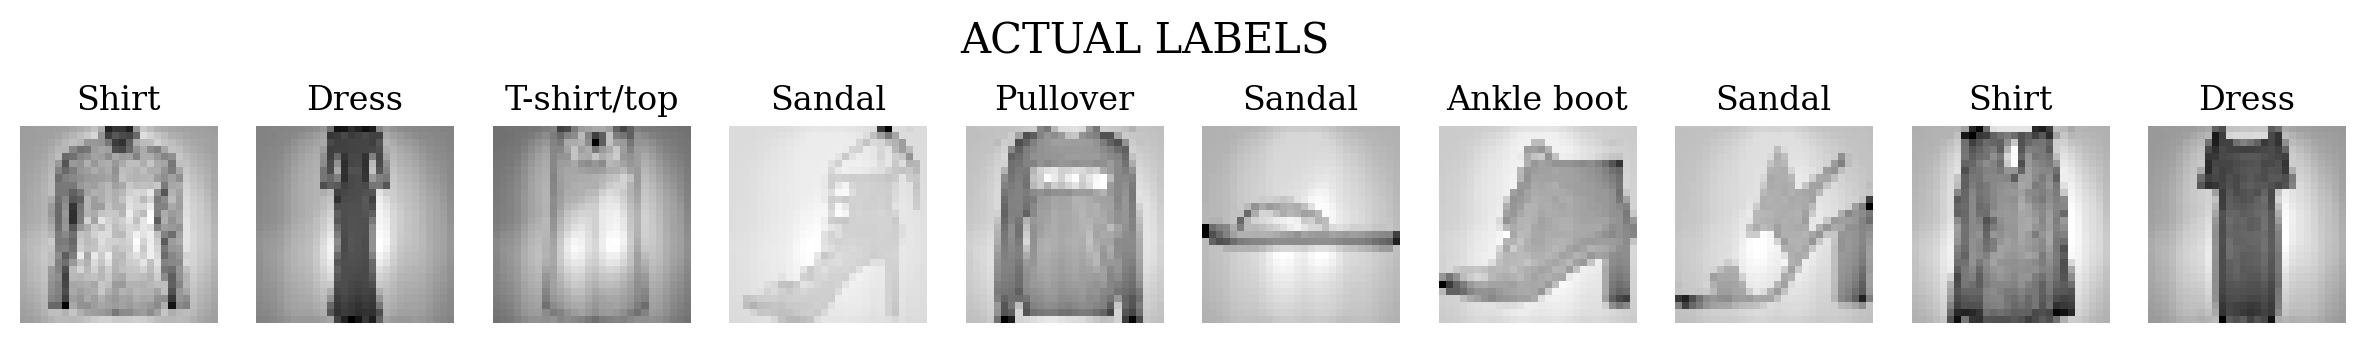

In [29]:
#Correct answers (y_test)
plt.figure(figsize=(15, 5))
for index, image in enumerate(X_new):
    plt.subplot(1, 10, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest", origin='upper')
    plt.axis('off')
    plt.title(class_names[y_test[idx10[index]]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.suptitle('ACTUAL LABELS',y=0.7,fontsize=15)
plt.show()

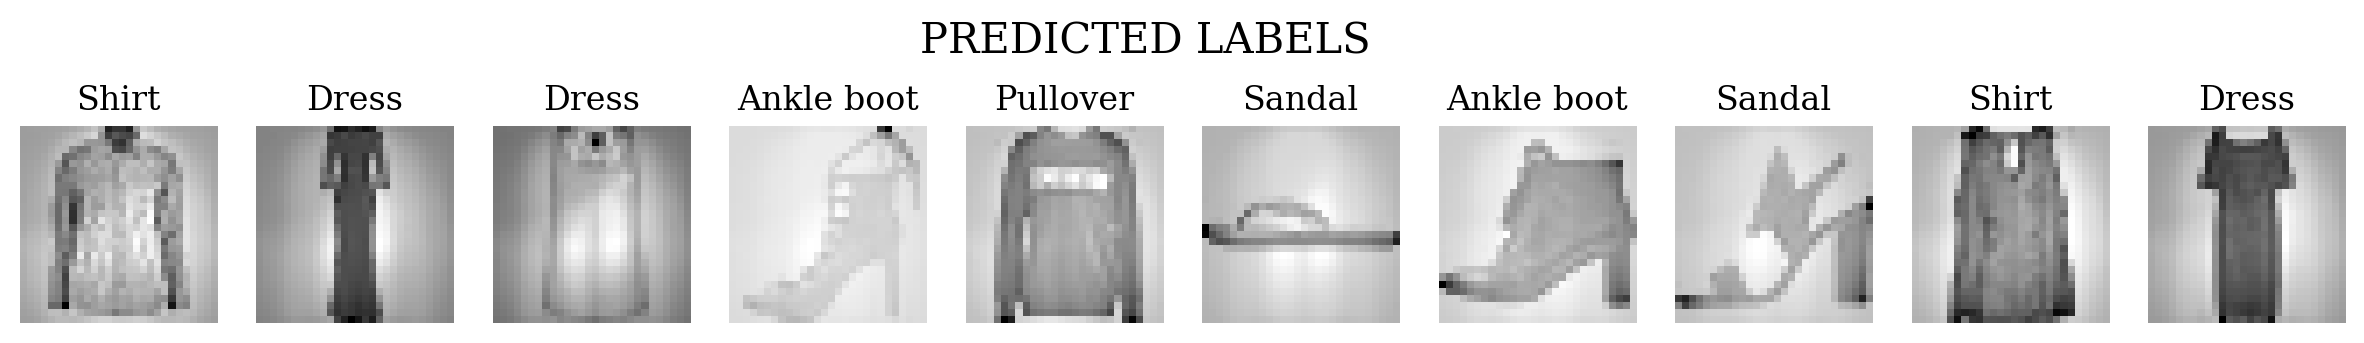

In [30]:
#Predicted answers (y_pred)
plt.figure(figsize=(15, 5))
for index, image in enumerate(X_new):
    plt.subplot(1, 10, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest", origin='upper')
    plt.axis('off')
    plt.title(class_names[y_pred[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.suptitle('PREDICTED LABELS',y=0.7,fontsize=15)
plt.show()

Not too shabby!

## Autoencoders <a class="anchor" id="three"></a>

**Autoencoders are neural networks that copy their input to their output, but after passing the data through a compression bottleneck**. For example if there are 28x28 = 784 inputs, there will also be 784 outputs, but there will be one or more (odd, but symmetric) hidden layers with fewer neuron than that.

***Therefore the encoder layers learn a compressed representation of the data, with the decoder layers transforming the encodings back to the full data dimensionality.*** 

For example see 

![autoencoder structure](https://miro.medium.com/max/1400/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png)

from
https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798

You can think of this as doing **PCA with a neural network** -- breaking our data down into the only the most important features that we actually *need* (finding the intrinsic dimensionality). In fact, if the network uses only linear (or no) activation functions and $L2$ cost function, then we have exactly PCA.  

How might this be useful?  Well, for example we can use it to reconstruct MNIST digits that have had noise added to them:

![autoencoder example](https://miro.medium.com/max/1400/1*SxwRp9i23OM0Up4sEze1QQ@2x.png)

More exciting possibilities are: 

- Using autoencoders for "**unsupervised pretraining**". For example you have data that is only partially labeled (at least not enough to do traditional supervised classification).  We can train an autoencoder on the full data set, then used the encoder part as the base of a regular neural network that is trained on the labeled data that we do have. This is found to be a much more efficient way of initializing weights and biases than starting from random, because you are "cheating" a bit by already figuring out some of the data structure using the autoencoder. See Geron Figure 17.6.
- **[Anomaly detection](https://scikit-learn.org/stable/modules/outlier_detection.html)**, e.g. https://towardsdatascience.com/anomaly-detection-with-autoencoder-b4cdce4866a6 and https://towardsdatascience.com/anomaly-detection-using-autoencoders-5b032178a1ea. See also
https://www.pyimagesearch.com/2020/03/02/anomaly-detection-with-keras-tensorflow-and-deep-learning/ and 
https://towardsdatascience.com/autoencoder-neural-network-for-anomaly-detection-with-unlabeled-dataset-af9051a048.

### Variational Autoencoders

More common in astronomy are **variational autoencoders**, partly because the "latent space" (i.e. the compressed representation of the data) that results from a standard autoencoder doesn't necessarily map continuously to the data (e.g., if your training data don't represent the possibilities or span of the full data space). 

We won't go into detail, just realize that these are something that you might try if you were otherwise going to try an autoencoder to tackle your problem. **Instead of the encoder layers compressing the data down to a single point in the "latent space", it is mapped to a continuous distribution** (imagine if PCA gave you a probabilistic compression). The prior on this continuous distribution is a Gaussian with mean and variance. ***Therefore the intuition for variational autoencoders is that the mean vector centers the average encoding of the data point, while the variance samples around this average encoding.*** This allows the encoding and decoding to interpolate much more smoothly across the training data. 

![Ivezic Figure 9.21](https://www.astroml.org/_images/fig_vae_1.png)

Let's build a variational autoencoder and train it on a sample of SDSS spectra. We'll switch back to `pytorch`. Grab the data, normalize and prepare for the network, then do a 3:1 train-test split.

In [31]:
from astroML.datasets import sdss_corrected_spectra
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

# Fetch and prepare the data
data = sdss_corrected_spectra.fetch_sdss_corrected_spectra()
spectra = sdss_corrected_spectra.reconstruct_spectra(data)
wavelengths = sdss_corrected_spectra.compute_wavelengths(data)

# normalize spectra by integrated flux and subtract out mean, for easier training
spectranorms = np.mean(spectra, axis=1)
normedspectra = spectra / spectranorms[:, None]
meanspectrum = np.mean(normedspectra, axis=0)
normedspectra -= meanspectrum[None, :]

# split data into 3:1 train:test
torch.manual_seed(802)  # seed used for book figure
dataset = torchdata.TensorDataset(torch.tensor(normedspectra))
trainnum = normedspectra.shape[0] // 4 * 3
traindata, testdata = torchdata.random_split(dataset, 
                                             [trainnum, normedspectra.shape[0] - trainnum])
traindataloader = torchdata.DataLoader(traindata, batch_size=128, shuffle=True)

Now define the structure of the variational autoencoder. 
- In the top block you can see that the first layer reduces the $1000$-D input down to $250$.
- We then pass to a $2$D mean and variance layer from which the compressed "latent" parameters can be probabilistically drawn. This means that we compressing down from a 1000 flux channels to a 2D compressed representation.
- The decoding layers decompress the sampled latent parameters and scale back up to the full 1000 flux channel dimensions.

In [32]:
# define structure of variation autoencoder
class VAE(nn.Module):
    def __init__(self, nhidden=250):
        super(VAE, self).__init__()

        # encoding layers
        self.encode_fc = nn.Linear(1000, nhidden)
        self.mu        = nn.Linear(nhidden, 2)
        self.logvar    = nn.Linear(nhidden, 2)

        # decoding layers
        self.decode_fc = nn.Linear(2, nhidden)
        self.output    = nn.Linear(nhidden, 1000)

    def encode(self, x):
        h = F.relu(self.encode_fc(x))
        return self.mu(h), self.logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h = F.relu(self.decode_fc(z))
        return self.output(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

The loss is a modified version of the usual MSE, where we use the **Kullback-Leibler divergence** to asses how close the latent parameter distribution is to a Gaussian. 

In [33]:
# add KL divergence to loss function
def VAEloss(criterion, recon_x, x, mu, logvar):
    return criterion(recon_x, x) - 0.5 * torch.sum(1 + logvar - 
                                                   mu.pow(2) - 
                                                   logvar.exp())

Another large block that is essentially just training the network.

In [34]:
def train_model():
    model = VAE()
    criterion = torch.nn.MSELoss(reduction='sum')
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                           verbose=True, 
                                                           patience=5, 
                                                           threshold=1e-3)

    min_valid_loss = float('inf')
    badepochs = 0
    for t in range(1000):
        train_loss = 0
        for i, databatch in enumerate(traindataloader, 0):
            specbatch = databatch[0]
            optimizer.zero_grad()
            recon, mu, logvar = model(specbatch)
            loss = VAEloss(criterion, recon, 
                           specbatch, mu, logvar)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        with torch.no_grad():
            testspec = testdata[:][0]
            recon, mu, logvar = model(testspec)
            valid_loss = VAEloss(criterion, recon, 
                                 testspec, mu, logvar)
            if t % 10 == 0:
                print('Epoch %3i: train loss %6.1f validation loss %6.1f' % \
                        (t, train_loss / len(traindata), valid_loss / len(testdata)))
            # stop training if validation loss has not fallen in 10 epochs
            if valid_loss > min_valid_loss*(1-1e-3):
                badepochs += 1
            else:
                min_valid_loss = valid_loss
                badepochs = 0
            if badepochs == 10:
                print('Finished training')
                break
        scheduler.step(valid_loss)
    return model

In [35]:
print(model)

<Sequential name=sequential, built=True>


Let's train this thing! (Takes less than a minute)

In [36]:
model = train_model()

/home/deshmus/Documents/GitHub/astr_8070_s25/venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch   0: train loss 2276.2 validation loss 1259.7
Epoch  10: train loss  423.4 validation loss  405.2
Epoch  20: train loss  233.2 validation loss  309.6
Epoch  30: train loss  181.3 validation loss  281.8
Epoch  40: train loss  149.1 validation loss  264.9
Epoch  50: train loss  147.0 validation loss  254.5
Epoch  60: train loss  112.9 validation loss  240.6
Epoch  70: train loss  100.7 validation loss  233.0
Epoch  80: train loss   94.7 validation loss  228.3
Epoch  90: train loss   97.7 validation loss  234.4
Finished training


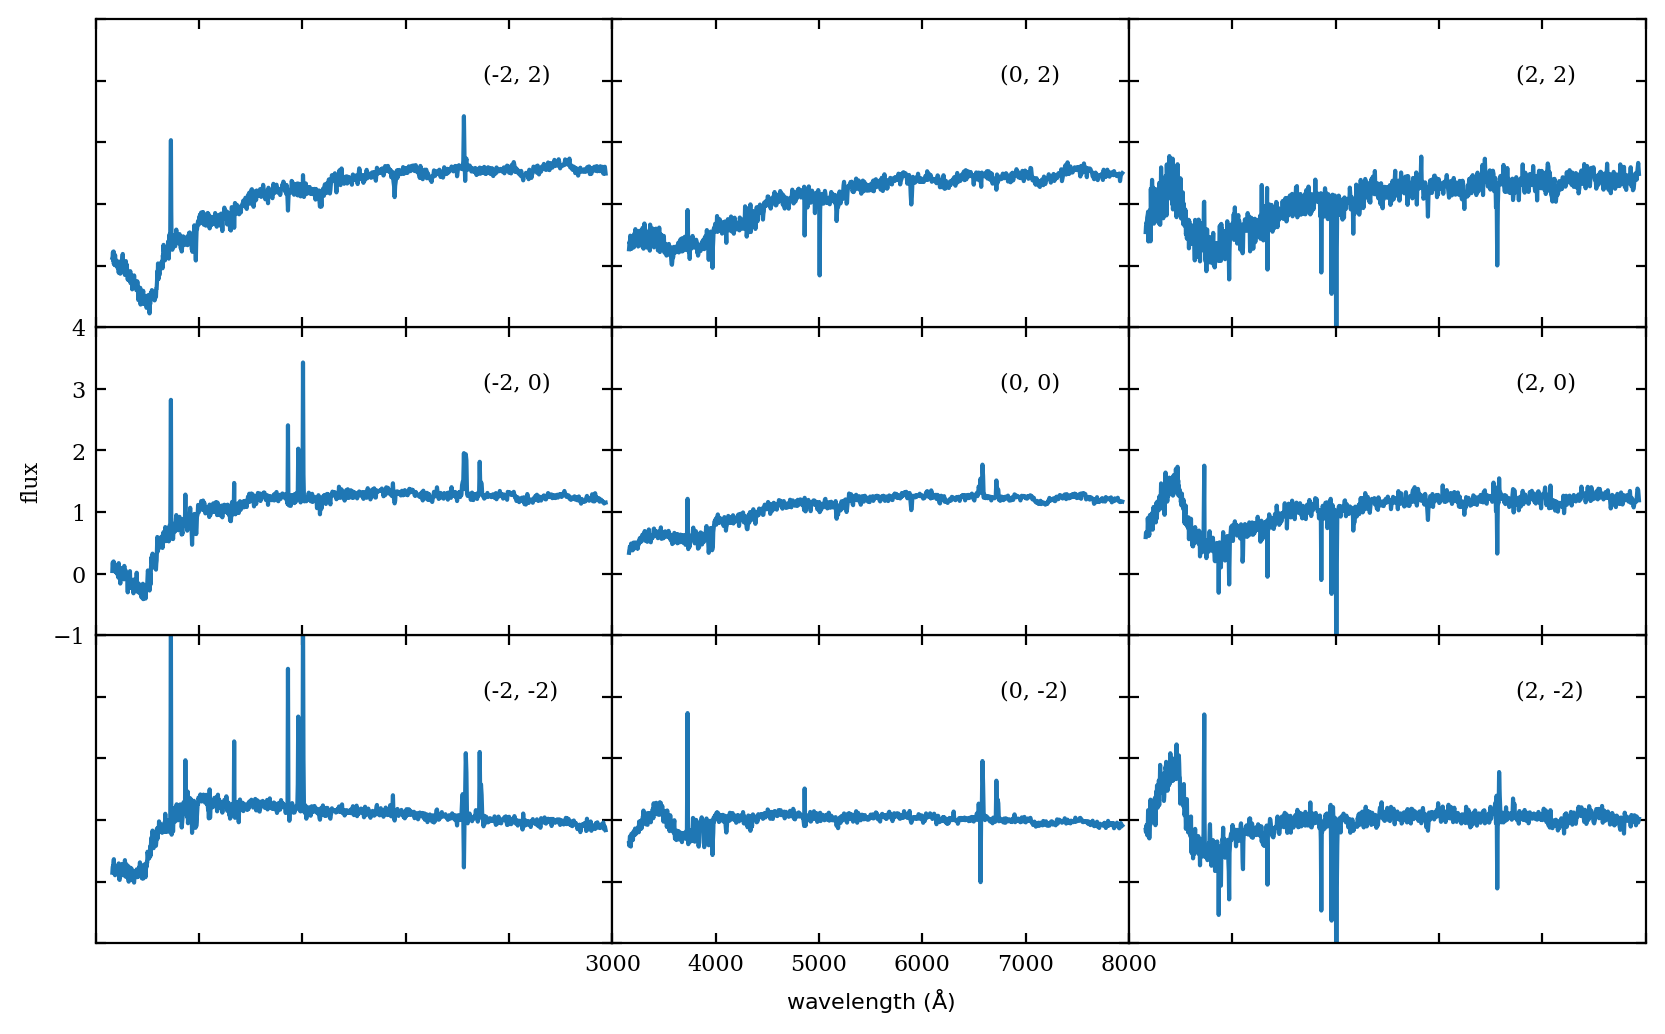

In [37]:
# plot results
with torch.no_grad():
    # sort latent parameters from most constrained to least constrained
    testspec = dataset[:][0]
    recon, mu, logvar = model(testspec)
    zorder = np.argsort(np.mean(logvar.numpy(), axis=0))

    fig = plt.figure(figsize=(10, 6))
    fig.subplots_adjust(hspace=0, wspace=0)
    parvalues = [-2.,0.,2.]
    for i, z1 in enumerate(parvalues):
        for j, z2 in enumerate(parvalues):
            # get z1 to vary left to right, z2 bottom to top
            ax = fig.add_subplot(3, 3, (2-j)*len(parvalues)+i+1)

            z = np.zeros((1,2), dtype=np.float32)
            z[0, zorder] = z1, z2 # set z1 is more constrained of the two latent parameters
            spectrum = model.decode(torch.tensor(z))
            ax.plot(wavelengths, meanspectrum+spectrum.numpy()[0,:])
            ax.text(6750, 3, '(%i, %i)' % (z1,z2))

            ax.set_xlim(3000, 8000)
            ax.set_ylim(-1, 4)

            if i == 0 and j == 1:
                ax.set_ylabel('flux')
            else:
                ax.yaxis.set_major_formatter(plt.NullFormatter())
            if j == 0 and i == 1:
                ax.set_xlabel(r'${\rm wavelength\ (\AA)}$')
            else:
                ax.xaxis.set_major_formatter(plt.NullFormatter())
plt.show()

The spectra above are generated from our variational autoencoder. As mentioned, the encoder was limited to two components (2D compressed latent space). As neurons are progressively activated in the latent space, we generate a smooth transition from spectra consistent with quiscent to star-forming galaxies. The numbers in each panel indicate the activation value of the two neurons in the latent space.

## Generative Adversarial Networks (GANs) <a class="anchor" id="four"></a>

Finally here's a brief discussion on GANs, since I teased them so much last time. GANs are pure evil, see
https://thispersondoesnotexist.com. The picture you see is not a real person-- it was generated by a neural network.

But they are also brilliant, incredibly useful, and relatively new (2014). The idea builds logically on autoencoders.
1. We have a generator (like the decoder part of an autoencoder) that can produce fake data (e.g., an image). 
2. Then we have a discriminator (a standard binary classifier) that tries to distinguish fake data from real.  
3. Then the generator learns to produce more and more accurate images to trick the discriminator -- without ever seeing any real images -- it just has the feedback from the discriminator.
4. We are pitting artifical neural networks against themselves to make them stronger. What could possibly go wrong, right?

![](https://learning.oreilly.com/library/view/java-deep-learning/9781788997454/assets/2cf8b4f1-7163-4af1-aa4b-6066329d554a.png)

For more, see
https://towardsdatascience.com/understanding-generative-adversarial-networks-gans-cd6e4651a29

Astronomy has seen some interesting uses of autoencoders and GANs in recent years.  For example:
    
- https://arxiv.org/abs/1702.00403    
- https://www.aanda.org/articles/aa/full_html/2017/07/aa30240-16/aa30240-16.html

and more generally applying deep networks to GW detection (my main interest):

- https://arxiv.org/pdf/1711.03121.pdf
- https://arxiv.org/pdf/1812.02183.pdf

## Normalizing Flows <a class="anchor" id="five"></a>

A normalizing flow is a type of deep learning architecture that allows for high-dimensional density estimation, and even conditional density estimation. These densities can be Bayesian posterior probability distributions, e.g., perhaps you want to learn the posterior for redshift given some galaxy colors. This is photo-z again, and can be treated with normalizing flows.

These normalizing flows (NFs) work by creating a chain of invertible transformations between a simple distribution, e.g., normal or uniform, and the complicated distribution under question or described by a dataset.

![](https://siboehm.com/assets/img/nfn/normalizing_flow.png)

The amazing thing about NFs is that they can be evaluated in both forward and backward directions. 

- So if you want to evaluate the probability density value of a point on your complicated distribution, you simply pass it back through the flow to be evaluated against your simple base distribution (normal or uniform).
- By contrast, if you want to generate new samples from your complicated distribution, simply draw random values from your base distribution, then pass those forward through the flow.

Let's look at an example, adapted from the `pzflow` documentation: https://jfcrenshaw.github.io/pzflow/tutorials/intro/

In [40]:
# !pip3 install pzflow

In [41]:
from pzflow import Flow
from pzflow.examples import get_twomoons_data

import jax.numpy as jnp

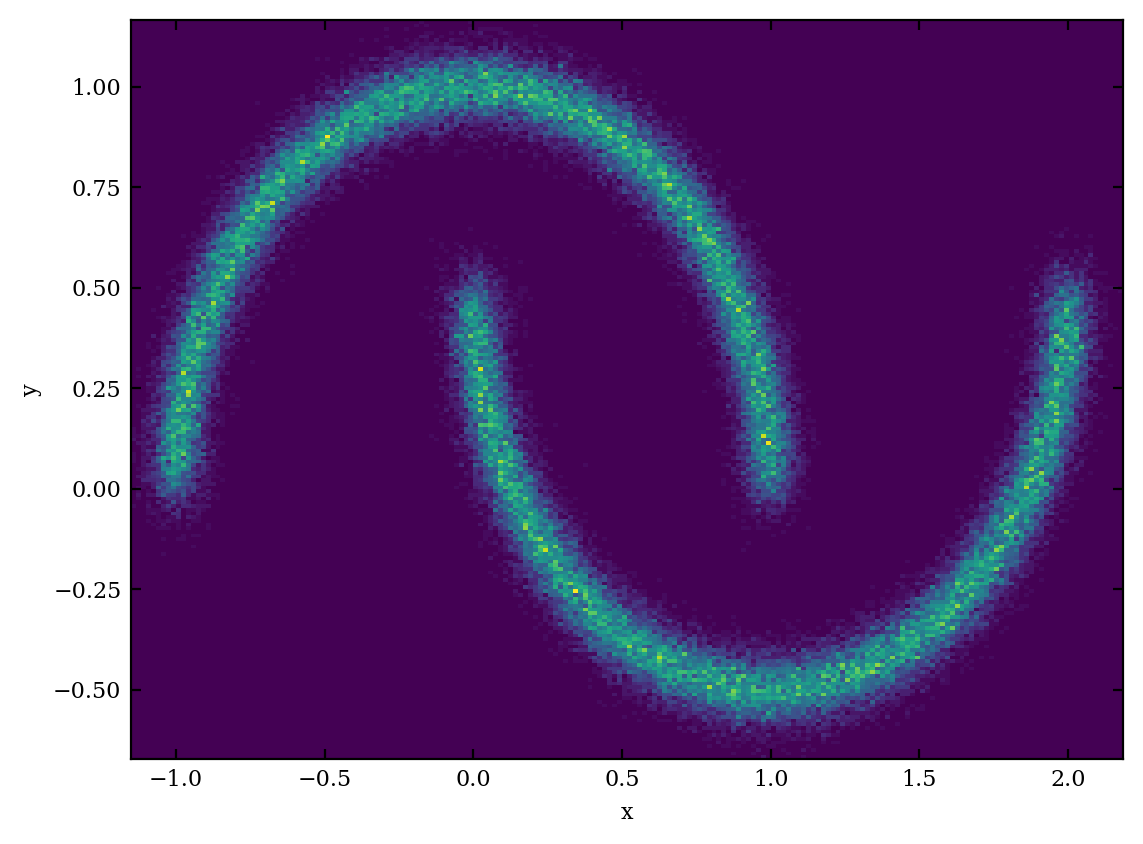

In [42]:
data = get_twomoons_data()

plt.hist2d(data["x"], data["y"], bins=200)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Now let's build a normalizing flow.
The details of constructing a normalizing flow are explored in the following tutorial notebooks, but for now, we can use the default flow built into PZFlow. 
This flow was designed to work well out-of-the-box for most data sets.

The only thing you are required to supply is the name of the columns in your data set.
As you can see in the pandas DataFrame above, our columns are named `"x"` and `"y"`.

In [43]:
flow = Flow(["x", "y"])

Now we can train our normalizing flow.
This is as simple as calling `flow.train(data)`.
There are several training parameters you can set, including the number of epochs, the batch size, the optimizer, and the random seed.
See the `Flow` documentation for more details.
For this example, let's use the defaults, but set `verbose=True` so that training losses are printed throughout the training process.

In [44]:
%%time
losses = flow.train(data, verbose=True)

Training 100 epochs 
Loss:
(0) 4.6523
(1) 0.8849
(6) 0.3417
(11) 0.3203
(16) 0.3146
(21) 0.3186
(26) 0.3078
(31) 0.3116
(36) 0.3115
(41) 0.3504
(46) 0.3119
(51) 0.3060
(56) 0.3012
(61) 0.2980
(66) 0.2988
(71) 0.3033
(76) 0.3068
(81) 0.3021
(86) 0.2966
(91) 0.2947
(96) 0.3184
(100) 0.2977
CPU times: user 4min 47s, sys: 18.4 s, total: 5min 5s
Wall time: 1min 19s


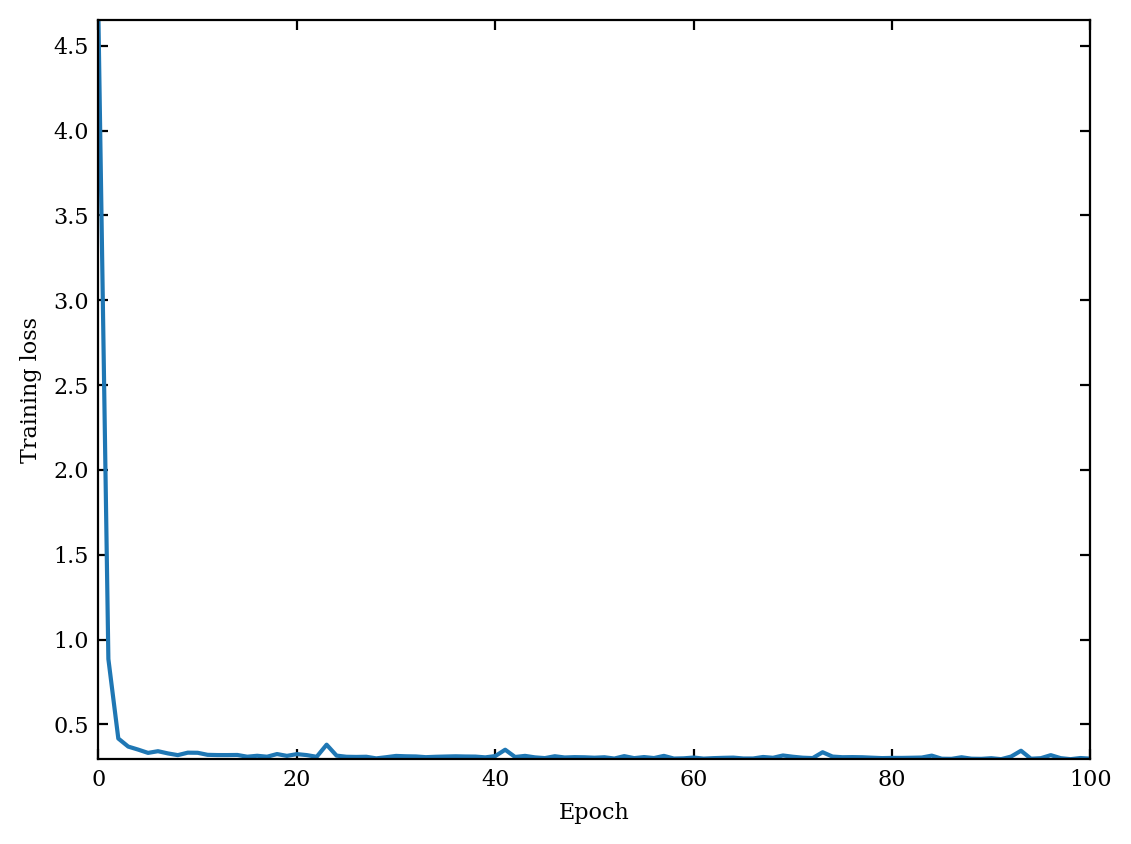

In [47]:
plt.plot(losses) # type: ignore
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.show()

Perfect!

Now we can draw samples from the flow, using the `sample` method.
Let's draw 10000 samples and make another histogram to see if it matches the data.

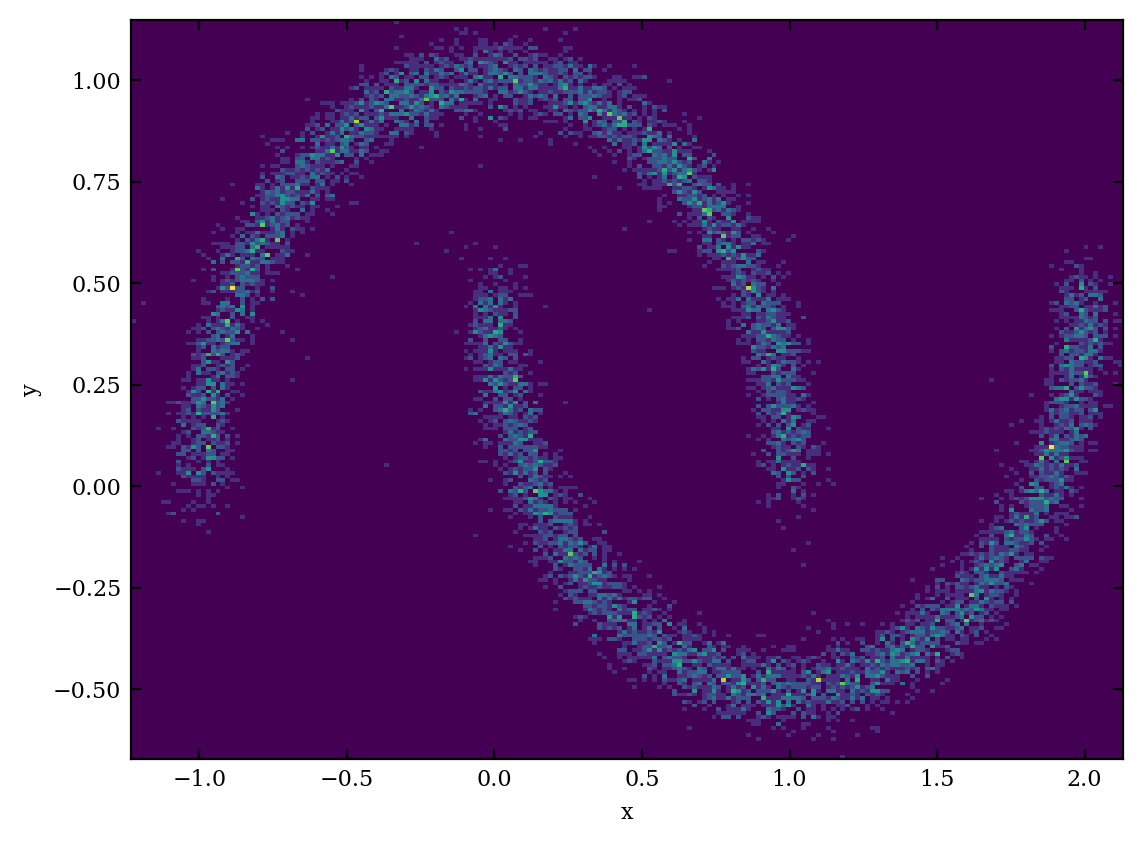

In [48]:
samples = flow.sample(10_000, seed=0)

plt.hist2d(samples["x"], samples["y"], bins=200)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Cool!

- It's not just sample generation from this complicated distribution that is made easy by the normalizing flow. 
- One can also evaluate the PDF of this very complicated two-means distribution.
- All we need to do is ``flow'' in the opposite direction. We transform the coordinates in the two-moons space back into space of the the base distribution, which is much simpler. It's easy to evaluate the PDF in the space of the base distribution. 

## Transformers <a class="anchor" id="six"></a>

**Transformer models** are the new kids on the block. They are incredibly powerful because they retain an understanding of context (or memory) over long lengthscales of data. This is called `attention`, and is what makes transformers far superior over other models like Recurrent Neural Networks (RNNs) and Long Short Term Memory (LSTM) networks. 

And you know ChatGPT? Well, GPT stands for Generative Pre-trained Transformer. All large language models are based on transformer architectures, and they are being used more for scientific research, e.g., time-series analysis.

Take a quick look at these resources:
- https://jalammar.github.io/illustrated-transformer/
- https://poloclub.github.io/transformer-explainer/

This graphic gives a relatively simple overview of what is happening. It is however intricate, and you'll need to think about this after class.
![Transformer Infographic](https://learn.g2.com/hs-fs/hubfs/G2CM_FI661_Learn_Article_Images-%5BTransformer_model_Infographic%5D_Image2_V1b-png.png?width=936&height=1300&name=G2CM_FI661_Learn_Article_Images-%5BTransformer_model_Infographic%5D_Image2_V1b-png.png)

Let's install a package to do time-series analysis and use one of it's transformer models to predict what a sine-wave will do next. Doesn't sound complicated, but remember-- the prediction is based on a very agnostic model. It does not assume any particular functional form like a sine wave.

In [50]:
# !pip3 install darts

In [51]:
# %pip install scikit-learn==1.1.3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Fix for scikit-learn ImportError in darts:
import sklearn.utils.validation
if not hasattr(sklearn.utils.validation, 'validate_data'):
	def validate_data(X, y=None, *, reset=True, validate_separately=False, **kwargs):
		return X, y
	sklearn.utils.validation.validate_data = validate_data

if not hasattr(sklearn.utils.validation, '_check_method_params'):
	from inspect import signature
	def _check_method_params(func, obj, params):
		sig = signature(func)
		for param in params:
			if param not in sig.parameters:
				raise TypeError(f"{func.__name__} got an unexpected keyword argument {param}")
	sklearn.utils.validation._check_method_params = _check_method_params

from darts import TimeSeries
from darts.models import TransformerModel

In [52]:

# Generate synthetic time series data (a noisy sine wave)
np.random.seed(42)
time = np.linspace(0, 20, 500)
data = np.sin(time) + 0.1 * np.random.randn(len(time))
dates = pd.date_range("2021-01-01", periods=len(data), freq="D")
series = TimeSeries.from_times_and_values(dates, data)


In [53]:

# Convert the series values to float32, since MPS doesn't support float64.
series = series.with_values(series.values().astype(np.float32))

# Split the data into training (80%) and validation (20%) sets
train, val = series.split_after(0.8)

# Define and train the Transformer model.
# The model parameters below (e.g., input_chunk_length) determine how many past points are used
# and how far ahead the model forecasts (output_chunk_length).
model = TransformerModel(
    input_chunk_length=30,
    output_chunk_length=1,
    batch_size=32,
    n_epochs=50,
    random_state=42,
    model_name="TransformerModel"
)
model.fit(train, verbose=True)


/home/deshmus/Documents/GitHub/astr_8070_s25/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_m

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


TransformerModel(output_chunk_shift=0, d_model=64, nhead=4, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=512, dropout=0.1, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=30, output_chunk_length=1, batch_size=32, n_epochs=50, random_state=42, model_name=TransformerModel)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

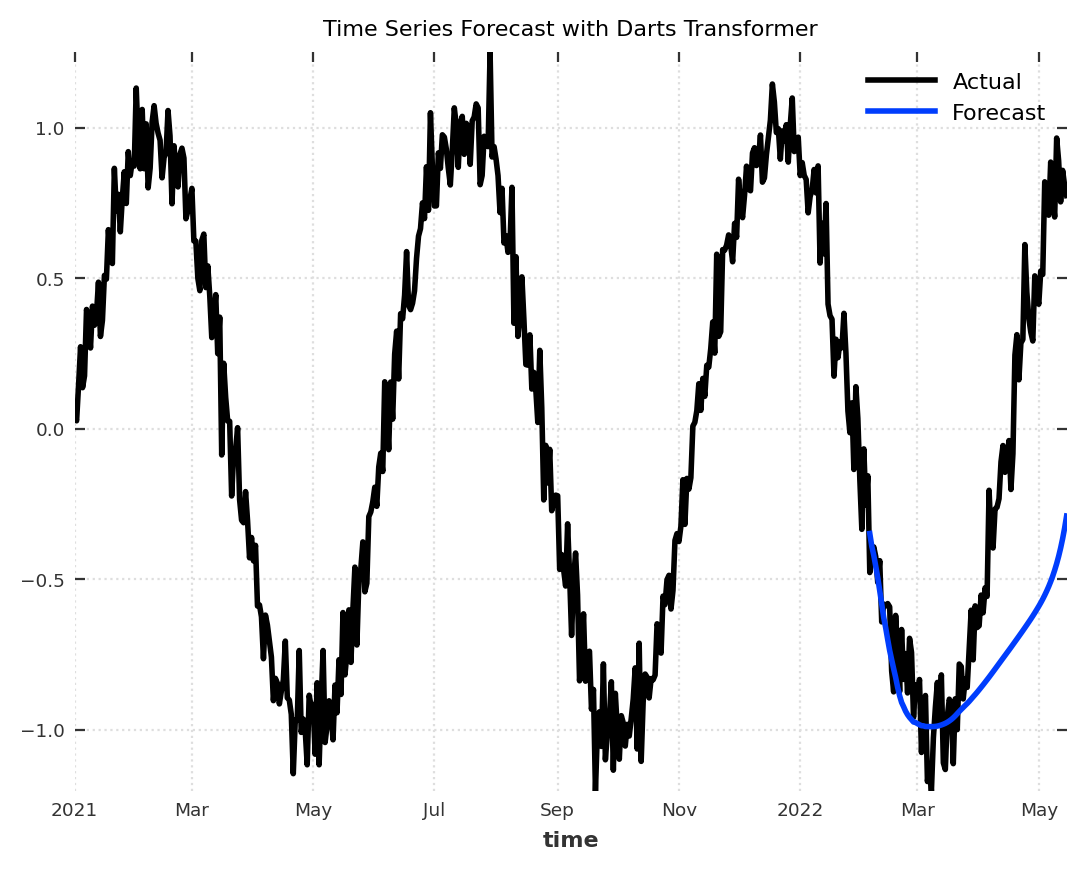

In [54]:

# Forecast for the length of the validation set
forecast = model.predict(len(val))

# Plot the actual series and the forecast
series.plot(label="Actual")
forecast.plot(label="Forecast", lw=2)
plt.title("Time Series Forecast with Darts Transformer")
plt.legend()
plt.show()

There is much more that could be discussed...  

But I'm afraid that is all the time we can spend on deep learning.

I'm not saying that you are ready for a data science job after these two lectures, but you now know more than the majority of astrophysicists that talk about neural networks, and you have used the two big codes. There are tons of useful videos, tutorials, and online courses that can take you further if you are interested in deep learning.

Another tool you may be interested in: https://astronn.readthedocs.io/en/latest/index.html